## Siamese Network

- Decide if two images belongs to the same person
- Chi-square similarity as feature vector which is symetric
- For face recognition we need a custom loss function called **contrastive loss**. For non matching faces the distance is 1 but for matching one it is different values. 
- We can adjust the threshold
- Validation set can be used for picking a good threshold value (good fp,fn,tp,tn)
- We can store only the embedding instead of the images

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

In [10]:
# Useful image utility
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)
from keras.preprocessing import image
from tensorflow.keras import utils

2024-06-26 15:28:47.790921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 15:28:48.344031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [11]:
!wget -nc https://www.kaggle.com/datasets/olgabelitskaya/yale-face-database 


--2024-06-26 15:29:04--  https://lazyprogrammer.me/course_files/yalefaces.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-06-26 15:29:06 ERROR 404: Not Found.



In [12]:
!unzip yalefaces.zip


Archive:  yalefaces.zip
  inflating: Readme.txt              
  inflating: data/Readme.txt         
  inflating: data/subject01.centerlight  
  inflating: data/subject01.glasses  
  inflating: data/subject01.happy    
  inflating: data/subject01.leftlight  
  inflating: data/subject01.noglasses  
  inflating: data/subject01.normal   
  inflating: data/subject01.rightlight  
  inflating: data/subject01.sad      
  inflating: data/subject01.sleepy   
  inflating: data/subject01.surprised  
  inflating: data/subject01.wink     
  inflating: data/subject02.centerlight  
  inflating: data/subject02.glasses  
  inflating: data/subject02.happy    
  inflating: data/subject02.leftlight  
  inflating: data/subject02.noglasses  
  inflating: data/subject02.normal   
  inflating: data/subject02.rightlight  
  inflating: data/subject02.sad      
  inflating: data/subject02.sleepy   
  inflating: data/subject02.surprised  
  inflating: data/subject02.wink     
  inflating: data/subject03.centerligh

In [15]:
files = glob('yalefaces/subject*')
np.random.shuffle(files)
N = len(files)
N

165

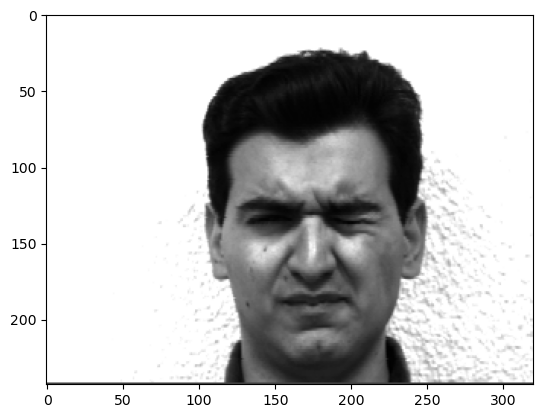

In [16]:
H, W = 60, 80
def load_img(filepath):
  # load image and downsample
  img = utils.img_to_array(utils.load_img(filepath, target_size=[H, W])).astype('uint8')
  return img

img = utils.load_img(np.random.choice(files))
plt.imshow(img)
plt.show()

In [17]:
np.array(img).shape


(243, 320, 3)

In [18]:
np.array(img).max()


255

In [19]:
def to_grayscale(img):
  return np.array(img).mean(axis=-1)

In [20]:
img = np.array(img)
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [21]:
shape = (N, H, W)
images = np.zeros(shape)
for i, f in enumerate(files):
  img = to_grayscale(load_img(f)) / 255.
  images[i] = img

In [22]:
labels = np.zeros(N)
for i, f in enumerate(files):
  filename = f.rsplit('/', 1)[-1]
  subject_num = filename.split('.', 1)[0]

  # subtract 1 since the filenames start from 1
  idx = int(subject_num.replace('subject', '')) - 1
  labels[i] = idx

In [23]:
label_count = Counter(labels)
label_count

Counter({7.0: 11,
         11.0: 11,
         1.0: 11,
         14.0: 11,
         9.0: 11,
         13.0: 11,
         0.0: 11,
         10.0: 11,
         12.0: 11,
         4.0: 11,
         3.0: 11,
         8.0: 11,
         2.0: 11,
         5.0: 11,
         6.0: 11})

In [27]:
unique_labels = set(label_count.keys())
n_subjects = len(label_count)
n_test = 3 * n_subjects
n_train = N - n_test
train_images = np.zeros((n_train, H, W))
train_labels = np.zeros(n_train)
test_images = np.zeros((n_test, H, W))
test_labels = np.zeros(n_test)

In [29]:
count_so_far = {}
train_idx = 0
test_idx = 0
images, labels = shuffle(images, labels)
for img, label in zip(images, labels):

  count_so_far[label] = count_so_far.get(label, 0) + 1

  if count_so_far[label] > 3:
    train_images[train_idx] = img
    train_labels[train_idx] = label
    train_idx += 1

  else:
    test_images[test_idx] = img
    test_labels[test_idx] = label
    test_idx += 1

In [30]:
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
  if label not in train_label2idx:
    train_label2idx[label] = [i]
  else:
    train_label2idx[label].append(i)

for i, label in enumerate(test_labels):
  if label not in test_label2idx:
    test_label2idx[label] = [i]
  else:
    test_label2idx[label].append(i)

In [31]:
train_positives = []
train_negatives = []
test_positives = []
test_negatives = []

for label, indices in train_label2idx.items():
  # all indices that do NOT belong to this subject
  other_indices = set(range(n_train)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      train_positives.append((idx1, idx2))

    for idx2 in other_indices:
      train_negatives.append((idx1, idx2))

for label, indices in test_label2idx.items():
  # all indices that do NOT belong to this subject
  other_indices = set(range(n_test)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      test_positives.append((idx1, idx2))

    for idx2 in other_indices:
      test_negatives.append((idx1, idx2))

In [32]:
batch_size = 64
def train_generator():
  # for each batch, we will send 1 pair of each subject
  # and the same number of non-matching pairs
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  
  while True:
    np.random.shuffle(train_positives)
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

      # fill up x_batch and y_batch
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 1 # match
        j += 1

      # get negative samples
      neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices), replace=False)
      for neg in neg_indices:
        idx1, idx2 = train_negatives[neg]
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 0 # non-match
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      # reshape
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      # convert to torch tensor
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [33]:
def test_generator():
  n_batches = int(np.ceil(len(test_positives) / batch_size))

  while True:
    n_samples = batch_size * 2
    shape = (n_samples, H, W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

      # fill up x_batch and y_batch
      j = 0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 1 # match
        j += 1

      # get negative samples
      neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices), replace=False)
      for neg in neg_indices:
        idx1, idx2 = test_negatives[neg]
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 0 # non-match
        j += 1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      # reshape
      x1 = x1.reshape(-1, 1, H, W)
      x2 = x2.reshape(-1, 1, H, W)

      # convert to torch tensor
      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1, x2], y

In [34]:
class SiameseNN(nn.Module):
  def __init__(self, feature_dim):
    super(SiameseNN, self).__init__()

    # define CNN featurizer
    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(13*18*64, 128), # 60>29>13,80>39>18
        nn.ReLU(),
        nn.Linear(128, feature_dim),
    )

  def forward(self, im1, im2):
    feat1 = self.cnn(im1)
    feat2 = self.cnn(im2)

    # Euclidean distance between feature 1 and feature 2
    return torch.norm(feat1 - feat2, dim=-1)

In [36]:
model = SiameseNN(50)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [37]:
# CUSTOM loss function for siamese network
def contrastive_loss(y, t):
  nonmatch = F.relu(1 - y) # max(margin - y, 0)
  return torch.mean(t * y**2 + (1 - t) * nonmatch**2)

In [38]:
optimizer = torch.optim.Adam(model.parameters())


In [39]:
def batch_gd(
    model,
    criterion,
    optimizer,
    train_gen,
    test_gen,
    train_steps_per_epoch,
    test_steps_per_epoch,
    epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    steps = 0
    for (x1, x2), targets in train_gen:
      # move data to GPU
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # Update steps
      steps += 1
      if steps >= train_steps_per_epoch:
        break

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    steps = 0
    for (x1, x2), targets in test_gen:
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
      outputs = model(x1, x2)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
      steps += 1
      if steps >= train_steps_per_epoch:
        break
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [40]:
train_steps = int(np.ceil(len(train_positives) / batch_size))
test_steps = int(np.ceil(len(test_positives) / batch_size))

train_losses, test_losses = batch_gd(
    model,
    contrastive_loss,
    optimizer,
    train_generator(),
    test_generator(),
    train_steps,
    test_steps,
    epochs=20)

Epoch 1/20, Train Loss: 0.7208,       Test Loss: 0.2727, Duration: 0:00:01.126264
Epoch 2/20, Train Loss: 0.2382,       Test Loss: 0.1963, Duration: 0:00:00.222268
Epoch 3/20, Train Loss: 0.1492,       Test Loss: 0.0930, Duration: 0:00:00.231139
Epoch 4/20, Train Loss: 0.0902,       Test Loss: 0.1545, Duration: 0:00:00.216504
Epoch 5/20, Train Loss: 0.0724,       Test Loss: 0.0848, Duration: 0:00:00.225418
Epoch 6/20, Train Loss: 0.0453,       Test Loss: 0.1052, Duration: 0:00:00.219700
Epoch 7/20, Train Loss: 0.0411,       Test Loss: 0.1135, Duration: 0:00:00.235150
Epoch 8/20, Train Loss: 0.0264,       Test Loss: 0.0953, Duration: 0:00:00.231039
Epoch 9/20, Train Loss: 0.0159,       Test Loss: 0.0982, Duration: 0:00:00.218882
Epoch 10/20, Train Loss: 0.0129,       Test Loss: 0.0947, Duration: 0:00:00.216593
Epoch 11/20, Train Loss: 0.0115,       Test Loss: 0.0906, Duration: 0:00:00.219364
Epoch 12/20, Train Loss: 0.0071,       Test Loss: 0.0906, Duration: 0:00:00.223275
Epoch 13/20, 

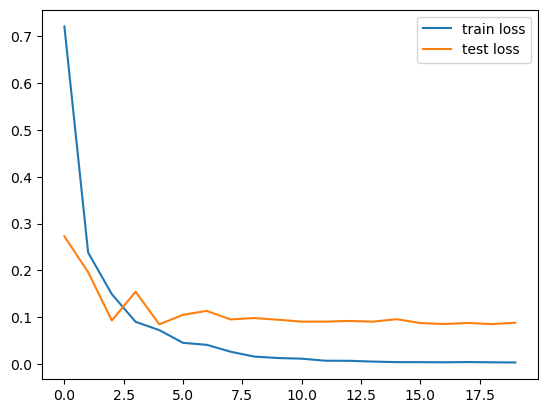

In [41]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [42]:
model.eval()


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [43]:
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [44]:
def get_train_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = train_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

In [45]:
def get_test_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(test_positives) / batch_size))
  for i in range(n_batches):
    print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = test_images[idx1]
      x_batch_2[j,0] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(test_negatives) / batch_size))
  for i in range(n_batches):
    print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = test_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()


  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

pos batch: 1/7
pos batch: 2/7
pos batch: 3/7
pos batch: 4/7
pos batch: 5/7
pos batch: 6/7
pos batch: 7/7
neg batch: 1/210
neg batch: 2/210
neg batch: 3/210
neg batch: 4/210
neg batch: 5/210
neg batch: 6/210
neg batch: 7/210
neg batch: 8/210
neg batch: 9/210
neg batch: 10/210
neg batch: 11/210
neg batch: 12/210
neg batch: 13/210
neg batch: 14/210
neg batch: 15/210
neg batch: 16/210
neg batch: 17/210
neg batch: 18/210
neg batch: 19/210
neg batch: 20/210
neg batch: 21/210
neg batch: 22/210
neg batch: 23/210
neg batch: 24/210
neg batch: 25/210
neg batch: 26/210
neg batch: 27/210
neg batch: 28/210
neg batch: 29/210
neg batch: 30/210
neg batch: 31/210
neg batch: 32/210
neg batch: 33/210
neg batch: 34/210
neg batch: 35/210
neg batch: 36/210
neg batch: 37/210
neg batch: 38/210
neg batch: 39/210
neg batch: 40/210
neg batch: 41/210
neg batch: 42/210
neg batch: 43/210
neg batch: 44/210
neg batch: 45/210
neg batch: 46/210
neg batch: 47/210
neg batch: 48/210
neg batch: 49/210
neg batch: 50/210
neg 

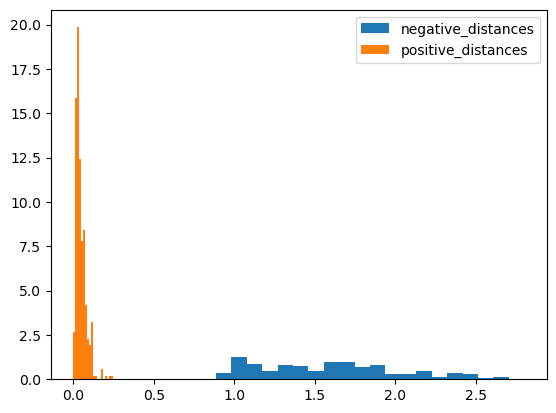

In [46]:
get_train_accuracy(0.65)
